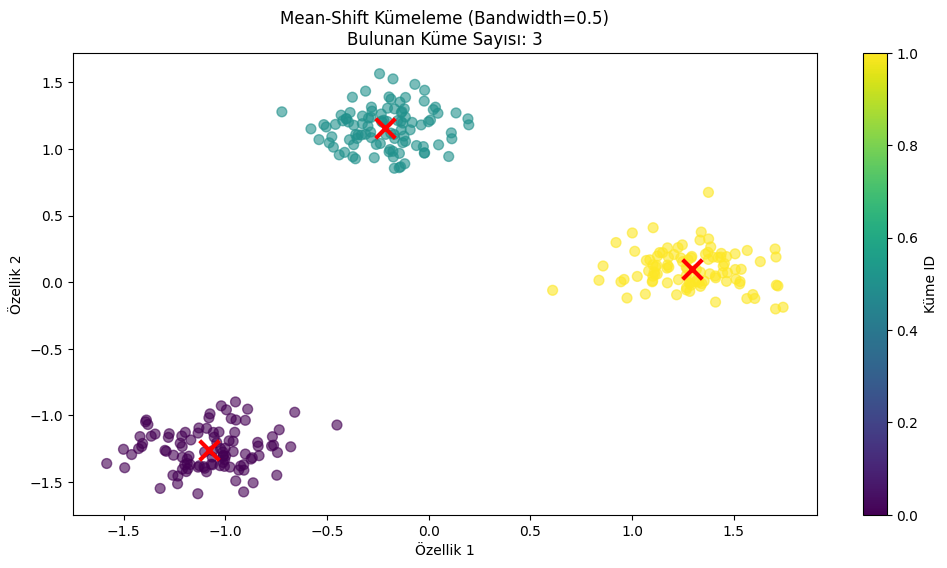

✅ Mean Shift benchmark verisi başarıyla eklendi.


In [4]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def save_to_benchmark(X, labels, accuracy=None):
    sil_score = silhouette_score(X, labels)
    calinski_score = calinski_harabasz_score(X, labels)
    davies_score = davies_bouldin_score(X, labels)

    benchmark_entry = {
        "vectorizer": "TF-IDF",
        "cluster_model": "Mean Shift",
        "accuracy": float(round(accuracy, 4)) if accuracy is not None else "N/A",
        "silhouette": float(round(sil_score, 4)),
        "calinski_harabasz": float(round(calinski_score, 4)),
        "davies_bouldin": float(round(davies_score, 4))
    }

    benchmark_path = "../../Outputs/benchmark.json"
    if os.path.exists(benchmark_path):
        with open(benchmark_path, "r", encoding="utf-8") as f:
            try:
                benchmark_data = json.load(f)
            except json.JSONDecodeError:
                benchmark_data = []
    else:
        benchmark_data = []

    benchmark_data.append(benchmark_entry)

    with open(benchmark_path, "w", encoding="utf-8") as f:
        json.dump(benchmark_data, f, indent=4, ensure_ascii=False)

    print(f"✅ Mean Shift benchmark verisi başarıyla eklendi.")


class MeanShift:
    def __init__(self, bandwidth=1.0, max_iterations=300, tol=1e-3):
        self.bandwidth = bandwidth  # Radyal komşuluk yarıçapı
        self.max_iterations = max_iterations
        self.tol = tol  # Yakınsama toleransı
        self.centroids = None  # Bulunan küme merkezleri
        self.labels = None  # Noktaların küme etiketleri

    def _gaussian_kernel(self, distances):
        """Gaussian çekirdek fonksiyonu ile ağırlıklandırma"""
        return np.exp(-0.5 * (distances / self.bandwidth) ** 2)

    def fit(self, X):
        n_samples = X.shape[0]

        # 1. Başlangıçta her nokta bir merkez kabul edilir
        centroids = np.copy(X)

        for _ in range(self.max_iterations):
            new_centroids = []

            # 2. Her nokta için kaydırma vektörü hesapla
            for i in range(n_samples):
                # 2a. Bandwidth içindeki komşuları bul
                distances = np.linalg.norm(centroids - centroids[i], axis=1)
                in_window = distances < self.bandwidth

                # 2b. Ağırlıkları hesapla (Gaussian kernel)
                weights = self._gaussian_kernel(distances[in_window])

                # 2c. Ağırlıklı ortalama ile yeni merkez hesapla
                if weights.sum() > 0:
                    new_center = np.sum(weights[:, np.newaxis] * centroids[in_window], axis=0) / weights.sum()
                    new_centroids.append(new_center)
                else:
                    new_centroids.append(centroids[i])

            new_centroids = np.array(new_centroids)

            # 3. Yakınsama kontrolü
            if np.linalg.norm(new_centroids - centroids) < self.tol:
                break

            centroids = new_centroids

        # 4. Benzersiz merkezleri bul (yakın olanları birleştir)
        unique_centroids = []
        for centroid in centroids:
            if not unique_centroids:
                unique_centroids.append(centroid)
            else:
                distances = np.linalg.norm(np.array(unique_centroids) - centroid, axis=1)
                if np.min(distances) > self.bandwidth * 0.5:  # Yarı bandwidth toleransı
                    unique_centroids.append(centroid)

        self.centroids = np.array(unique_centroids)

        # 5. Noktaları en yakın merkeze ata
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        self.labels = np.argmin(distances, axis=1)

        return self

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

#--------------------------------------------------
# Test ve Görselleştirme
#--------------------------------------------------
# Örnek veri oluştur (3 küme)
X, _ = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=42)
X = StandardScaler().fit_transform(X)

# Modeli oluştur ve eğit
ms = MeanShift(bandwidth=0.5)
ms.fit(X)

# Sonuçları görselleştir
plt.figure(figsize=(12, 6))
plt.scatter(X[:, 0], X[:, 1], c=ms.labels, cmap='viridis', s=50, alpha=0.6)
plt.scatter(ms.centroids[:, 0], ms.centroids[:, 1], marker='x', color='red', s=200, linewidths=3)
plt.title(f"Mean-Shift Kümeleme (Bandwidth={ms.bandwidth})\nBulunan Küme Sayısı: {len(ms.centroids)}")
plt.xlabel("Özellik 1")
plt.ylabel("Özellik 2")
plt.colorbar(label="Küme ID")
plt.show()

save_to_benchmark(X, ms.labels)